## OPC PDG

# Integrantes: Sandra Niño y Johnatan Garzón

En el presente jupyter notebook se hará uso de LDA (Latent Dirichlet Allocation) para que las respuestas a la pregunta "Para ti,¿Que sí es paz?", en este caso entendidos como documentos, formen topics o categorías de palabras relacionadas  a la pregunta.

In [1]:
%matplotlib inline
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression # modelos lineales
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score #protocolo de evaluación
from sklearn import datasets, metrics
from sklearn import preprocessing
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\sami_\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
dfEncuestaSPCC=pd.read_excel('./data/encuesta_SPCC-25ABR2018-MODIFICADA-ORTOGRAFIA.xlsx')

In [3]:
dfPazUSC=pd.read_excel('./data/marco_PAZ_USC_09ABR2019_latest_version_False_2019-MAY-09_0936-MODIFICADA-ORTOGRAFIA.xlsx')

In [4]:
dfNarrativasMayo=pd.read_excel('./data/respaldo_actualizacion_NARRATIVAS-10MAY2019-0600-MODIFICADA-ORTOGRAFIA.xlsx')

# Exploración y preparación de datos

## DfEncuestaSPCC

In [5]:
dfEncuestaSPCC.head()

,¿Cuál es el sistema operativo de su dispositivo móvil?,Nombre/s:,Apellido/s:,Sexo,Edad,¿Nació en Cali?,¿En qué departamento nació?,¿En qué municipio nació?,"De acuerdo con su cultura, pueblo o rasgos físicos usted es o se reconoce como:",¿Cuántas personas componen su hogar?,...,Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Alimentación,Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Derecho a la vivienda digna,"Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/No acoso (sexual, laboral)",Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Primera infancia,Escriba una frase corta en la que exprese su significado de la Paz:,Escriba un deseo de Paz para los demás:,Sugerencias específicas para medir ¿qué si es Paz?:,Sugerencias específicas para mejorar las capacidades de la SPCC:,Sugerencias específicas al OPC para una futura encuesta:,_index
0,Android,Gregorry,Rivera Garibello,Hombre,25,Si,NaN,NaN,Ninguno de los anteriores,4,...,0,0,0,0,"La humanización del espacio, ese siempre será ...","La búsqueda sigue su curso, un gran camino ocu...",Vamos bien!!!,"Más apoyo entre equipos, para mejorar la comun...",Que sea más corta,1
1,Android,Mauricio,Sedano,Hombre,43,No,Santander,Barrancabermeja,"Negro(a), mulato(a) y afrocolombiano(a)",2,...,0,0,0,0,Mantener las familias unidas,"Identificar lo que sí es paz, y emitir recomen...","diseñar inclusión y representatividad, procesa...",Dar cursos cortos online y certificados como E...,No combinar sectores con tipos de experiencias...,2
2,Android,Andrés Felipe,Suárez Sánchez,Hombre,31,Si,NaN,NaN,Ninguno de los anteriores,2,...,0,0,0,0,La paz es satisfacer los derechos básicos cons...,Trabajemos junto en asegurar los derechos bási...,Incluir una muestra de todos los grupos social...,Promover la auto formación virtual para ser es...,Planear un poco mejor el proceso de realizació...,3
3,Android,Ana María,Gálvez Yepes,Mujer,27,Si,NaN,NaN,Ninguno de los anteriores,4,...,0,0,0,0,La paz es el bien común,"Deseo que tus días estén llenos de fuerza, fel...",Tener en cuenta la voz de las comunidades,Crear una herramieta de impacto que permita po...,Sintetizar la introducción,4
4,iOS (Iphone),Ana Cristina,Alzate Restrepo,Mujer,39,No,Antioquia,Medellín,Ninguno de los anteriores,1,...,0,0,0,0,Concertación,Tolerancia con el otro en todo momento y lugar,Conocer por medio de casos puntuales el nivel ...,Formación en proyectos sociales: formulacion y...,Medir temas de clima organizacional como una a...,5


In [6]:
dfEncuestaSPCC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Columns: 221 entries, ¿Cuál es el sistema operativo de su dispositivo móvil? to _index
dtypes: float64(64), int64(58), object(99)
memory usage: 221.1+ KB


In [7]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['¿Cuál es el sistema operativo de su dispositivo móvil?',
 'Nombre/s:',
 'Apellido/s:',
 'Sexo',
 'Edad',
 '¿Nació en Cali?',
 '¿En qué departamento nació?',
 '¿En qué municipio nació?',
 'De acuerdo con su cultura, pueblo o rasgos físicos usted es o se reconoce como:',
 '¿Cuántas personas componen su hogar?',
 'Actualmente las condiciones de vida en su hogar son:',
 'En relación al hogar donde se crió en su primera infancia, su hogar actual vive económicamente:',
 'Usted piensa que el nivel de vida actual de su hogar, respecto al que tenía 5 años atrás, es:',
 'Selecciona, según la estructura del organismo de la que haces parte:',
 'Seleccione el proyecto para el cual trabaja',
 'Especifique',
 '¿Cuál es su principal función en el proyecto?',
 '¿Cuál es el problema central que trata de resolver su proyecto?',
 '¿Qué metodología/s de trabajo destacaría/s del proyecto?, ¿por qué?',
 'Indique cinco (5x) palabras claves para su proyecto',
 'Advierta cinco (5x) palabras claves que NO son 

Como podemos apreciar esta encuesta fue demasiado extensa. Las columnas que nos interesan son:  'Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”', 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz' y  'Escriba una frase corta en la que exprese su significado de la Paz:'

In [8]:
dfEncuestaSPCC.columns.get_loc('Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”')

23

In [9]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 0:23], inplace = True, axis = 1) 

In [10]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Mencione tres (3x) palabras claves para la RECONCILIACIÓN',
 '¿Cuál es tu lugar de residencia?:',
 'Comuna:',
 'Barrio:',
 'Corregimiento:',
 'Vereda:',
 'Otros nombres utilizados para referirse a tu Barrio / Vereda / Zona / Sector:',
 'Departamento:',
 'Municipio:',
 'Tiempo de residencia:',
 '¿Qué tan satisfecho se siente de vivir en ese barrio o corregimiento?',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido víctima usted o algún miembro del hogar dentro de su barrio o vereda?',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido víctima usted o algún miembro del hogar dentro de su barrio o vereda?/Atracos o robos',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido víctima usted o algún miembro del hogar dentro de su barrio o vereda?/Homicidios o asesinatos',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido ví

In [11]:
dfEncuestaSPCC.columns.get_loc("Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz")

166

In [12]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 1:166], inplace = True, axis = 1) 

In [13]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Respeto',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Tolerancia',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Armonía',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Hogar',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Entorno protector',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/No discriminación',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Amor',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Compartir',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Pa

In [14]:
dfEncuestaSPCC.columns.get_loc("Escriba una frase corta en la que exprese su significado de la Paz:")

27

In [15]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 2:27], inplace = True, axis = 1) 

In [16]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
 'Escriba una frase corta en la que exprese su significado de la Paz:',
 'Escriba un deseo de Paz para los demás:',
 'Sugerencias específicas para medir ¿qué si es Paz?:',
 'Sugerencias específicas para mejorar las capacidades de la SPCC:',
 'Sugerencias específicas al OPC para una futura encuesta:',
 '_index']

In [17]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 3:8], inplace = True, axis = 1) 

In [18]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
 'Escriba una frase corta en la que exprese su significado de la Paz:']

Finalmente logramos obtener las 3 columnas que nos interesaban

## dfPazUSC

In [19]:
dfPazUSC.head()

,start,end,today,username,simserial,subscriberid,deviceid,phonenumber,equipo,punto_captura,...,municipio,cargo,facultad,programa_academico,__version__,_id,_uuid,_submission_time,_validation_status,_index
0,2019-04-09T10:45:13.267-05,2019-04-09T11:10:35.529-05,2019-04-09,datospazcali,89571015019090214468,732101527021446,351712103831066,NaN,equipo_6,bloque_5,...,NaN,funcionario_operativo,NaN,NaN,vTnXvdYjdSdY5wARMg2L5Q,25553871,11f1cd0d-ba51-4a6f-afcd-95b2e120158c,2019-04-09T17:37:52,NaN,1
1,2019-04-09T11:14:49.149-05,2019-04-09T11:29:32.972-05,2019-04-09,datospazcali,8957123401818574217,732123630899421,358126076228817,NaN,equipo_6,bloque_5,...,NaN,estudiante,NaN,NaN,vTnXvdYjdSdY5wARMg2L5Q,25553956,c8477283-ae3e-45e8-9e9f-9d65b0222aac,2019-04-09T17:38:35,NaN,2
2,2019-04-09T11:30:09.295-05,2019-04-09T11:32:31.353-05,2019-04-09,datospazcali,8957123401818574217,732123630899421,358126076228817,NaN,equipo_6,bloque_5,...,NaN,estudiante,salud,medicina,vTnXvdYjdSdY5wARMg2L5Q,25553957,d3608c8b-5dd3-46fe-851c-af07d3eb53e2,2019-04-09T17:38:36,NaN,3
3,2019-04-09T10:23:40.386-05,2019-04-09T10:34:34.074-05,2019-04-09,datospazcali,89571015021013409001,732101543311682,353779105621165,NaN,tecnico_OPC,entrada_KL_5ta,...,76306.0,estudiante,derecho,derecho,vTnXvdYjdSdY5wARMg2L5Q,25546856,29d3b696-4f20-4df5-b5ea-5c922a589d43,2019-04-09T15:35:10,NaN,4
4,2019-04-09T10:21:54.412-05,2019-04-09T10:34:35.893-05,2019-04-09,datospazcali,89571015017080727838,732101502072783,355656080709710,NaN,tecnico_OPC,entrada_KL_5ta,...,NaN,estudiante,derecho,derecho,vTnXvdYjdSdY5wARMg2L5Q,25546861,9519762f-e31c-4842-a2cb-abee7d6ecfaf,2019-04-09T15:35:13,NaN,5


In [20]:
cols = dfPazUSC.columns.tolist()
cols

['start',
 'end',
 'today',
 'username',
 'simserial',
 'subscriberid',
 'deviceid',
 'phonenumber',
 'equipo',
 'punto_captura',
 'narrativa_paz',
 'componentes',
 'componentes/tranquilidad',
 'componentes/familia_hogar',
 'componentes/vecinos_amigos',
 'componentes/convivencia',
 'componentes/narutaleza',
 'componentes/no_violencia',
 'componentes/zonas_verdes',
 'componentes/démas_personas',
 'componentes/respeto',
 'componentes/comunidad',
 'componentes/espiritualidad',
 'componentes/no_discriminación',
 'componentes/amor',
 'componentes/tradiciones_familiares',
 'componentes/libertad',
 'componentes/derechos_sociales',
 'componentes/salud',
 'componentes/educación',
 'componentes/derechos_espacio_publico',
 'componentes/perdón',
 'componentes/empleo',
 'componentes/reconocimiento',
 'componentes/reconciliación',
 'sexo',
 'edad',
 'departamento_nacimiento',
 'municipio_nacimiento',
 'zona_residencia',
 'comuna',
 'barrio',
 'corregimiento',
 'vereda',
 'otro_sector',
 'departament

La unica columna que nos interesa es: 'narrativa_paz'

In [21]:
dfPazUSC.columns.get_loc("narrativa_paz")

10

In [22]:
dfPazUSC.drop(dfPazUSC.iloc[:, 0:10], inplace = True, axis = 1) 

In [23]:
cols = dfPazUSC.columns.tolist()
cols

['narrativa_paz',
 'componentes',
 'componentes/tranquilidad',
 'componentes/familia_hogar',
 'componentes/vecinos_amigos',
 'componentes/convivencia',
 'componentes/narutaleza',
 'componentes/no_violencia',
 'componentes/zonas_verdes',
 'componentes/démas_personas',
 'componentes/respeto',
 'componentes/comunidad',
 'componentes/espiritualidad',
 'componentes/no_discriminación',
 'componentes/amor',
 'componentes/tradiciones_familiares',
 'componentes/libertad',
 'componentes/derechos_sociales',
 'componentes/salud',
 'componentes/educación',
 'componentes/derechos_espacio_publico',
 'componentes/perdón',
 'componentes/empleo',
 'componentes/reconocimiento',
 'componentes/reconciliación',
 'sexo',
 'edad',
 'departamento_nacimiento',
 'municipio_nacimiento',
 'zona_residencia',
 'comuna',
 'barrio',
 'corregimiento',
 'vereda',
 'otro_sector',
 'departamento',
 'municipio',
 'cargo',
 'facultad',
 'programa_academico',
 '__version__',
 '_id',
 '_uuid',
 '_submission_time',
 '_validati

In [24]:
len(cols)

46

In [25]:
dfPazUSC.drop(dfPazUSC.iloc[:, 1:47], inplace = True, axis = 1) 

In [26]:
cols = dfPazUSC.columns.tolist()
cols

['narrativa_paz']

Finalmente obtuvimos la columna que nos interesaba

## dfNarrativasMayo

In [27]:
dfNarrativasMayo.head()

,_orden,pre_INDEX entrada_KOBO,_grupo,index_MA salida_KOBO,caso
0,1,1,n15FEB2017,299.0,sin_INDEX
1,2,2,n15FEB2017,33.0,sin_INDEX
2,3,3,n15FEB2017,375.0,con_INDEX
3,4,4,n15FEB2017,396.0,sin_INDEX
4,5,5,n15FEB2017,649.0,sin_INDEX


In [28]:
dfNarrativasMayo = pd.ExcelFile('./data/respaldo_actualizacion_NARRATIVAS-10MAY2019-0600-MODIFICADA-ORTOGRAFIA.xlsx')

Esta fuente de datos tiene varias hojas (Sheets), exactamente 6, por tanto debemos examinarlas una por una para extraer la información

In [29]:
dfSheet1 = pd.read_excel(dfNarrativasMayo, sheet_name="registros_ma-n15FEB2017")

In [30]:
dfSheet1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,1,2,3,4,5,...,128,129,130,131,132,133,134,135,136,137
0,NaN,NaN,NaN,header_listo,NaN,responsable,NaN,nombre,apellido,barrio,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
1,NaN,NaN,NaN,NaN,NaN,n15FEB2017-59x,n15FEB2017-59x,n15FEB2017-59x,n15FEB2017-59x,n15FEB2017-59x,...,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,escenario
2,_indice_HORIZONTAL,NaN,NaN,NaN,NaN,1,2,3,4,5,...,69,70,71,72,73,74,75,76,77,78
3,NaN,NaN,NaN,NaN,NaN,Responsable:,NaN,Nombre:,Apellido:,Barrio:,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
4,_orden,_index,_grupo,_index_MA,caso,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
dfSheet1.columns.get_loc(55)

59

In [32]:
dfSheet1.drop(dfSheet1.iloc[:, 0:59], inplace = True, axis = 1) 

In [33]:
cols = dfSheet1.columns.tolist()


In [34]:
len(cols)

83

In [35]:
dfSheet1.drop(dfSheet1.iloc[:, 1:84], inplace = True, axis = 1) 

In [36]:
cols = dfSheet1.columns.tolist()
cols

[55]

In [37]:
dfSheet1.head(10)

,55
0,texto
1,n15FEB2017-59x
2,55
3,Texto
4,NaN
5,NaN
6,convivencia pacifica con los demás y amor
7,No aparece
8,No aparece cuadro de datos
9,La Paz para mi es tener claridad sobre las cos...


In [38]:
dfSheet1.drop([0,1,2,3,4,5], inplace= True)

In [39]:
dfSheet1.head()

,55
6,convivencia pacifica con los demás y amor
7,No aparece
8,No aparece cuadro de datos
9,La Paz para mi es tener claridad sobre las cos...
10,Para mi la Paz representa tranquilidad


In [40]:
dfSheet1.iloc[0:6]

,55
6,convivencia pacifica con los demás y amor
7,No aparece
8,No aparece cuadro de datos
9,La Paz para mi es tener claridad sobre las cos...
10,Para mi la Paz representa tranquilidad
11,la paz para mi creo que es vivir sin violencia...


In [41]:
dfSheet2 = pd.read_excel(dfNarrativasMayo, sheet_name="registros_ma-n16FEB2017")

In [42]:
dfSheet2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,1,2,3,4,5,...,126,127,128,129,130,131,132,133,134,135
0,NaN,NaN,NaN,NaN,NaN,responsable,nombre,apellido,edad,sexo,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
1,NaN,NaN,NaN,NaN,NaN,n16FEB2017-57x,n16FEB2017-57x,n16FEB2017-57x,n16FEB2017-57x,n16FEB2017-57x,...,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,escenario
2,_indice_HORIZONTAL,NaN,NaN,NaN,NaN,1,2,3,4,5,...,69,70,71,72,73,74,75,76,77,78
3,NaN,NaN,NaN,NaN,NaN,Responsable:,Nombre:,Apellido:,Edad,Sexo,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
4,_orden,_index,_grupo,_index_MA,caso,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
dfSheet2.columns.get_loc(6)

10

In [44]:
dfSheet2.drop(dfSheet2.iloc[:, 0:10], inplace = True, axis = 1) 

In [45]:
cols = dfSheet2.columns.tolist()
len(cols)

130

In [46]:
dfSheet2.drop(dfSheet2.iloc[:, 1:131], inplace = True, axis = 1) 

In [47]:
dfSheet2.head(10)

,6
0,texto
1,n16FEB2017-57x
2,6
3,Texto
4,NaN
5,Para mi paz es poder compartir con los demás y...
6,la paz es una construcción social que se gesta...
7,la paz es la ausencia de factores de generador...
8,Si aportamos nuestro grano de arena empezando ...
9,la paz es pasar rato con mi familia


In [48]:
dfSheet2.drop([0,1,2,3,4], inplace= True)

In [49]:
dfSheet2.head()

,6
5,Para mi paz es poder compartir con los demás y...
6,la paz es una construcción social que se gesta...
7,la paz es la ausencia de factores de generador...
8,Si aportamos nuestro grano de arena empezando ...
9,la paz es pasar rato con mi familia


In [50]:
dfSheet3 = pd.read_excel(dfNarrativasMayo, sheet_name="registros_ma-n01AGO2018")

In [51]:
dfSheet3.columns.get_loc(32)

36

In [52]:
dfSheet3.drop(dfSheet3.iloc[:, 0:36], inplace = True, axis = 1) 

In [53]:
cols = dfSheet3.columns.tolist()
len(cols)

165

In [54]:
dfSheet3.drop(dfSheet3.iloc[:, 1:166], inplace = True, axis = 1) 

In [55]:
dfSheet3.head(10)

,32
0,narrativa_text
1,n01AGO2018-118x
2,32
3,narrativa_text
4,NaN
5,"Para mi paz es cuidar la naturaleza, ser cons..."
6,La paz es tener principios morales y espiritua...
7,Paz es saber convivir en comunidad respetando ...
8,La paz para mi es que mi hijo y los demás niño...
9,La paz es aprender a convivir y respetar a las...


In [56]:
dfSheet3.drop([0,1,2,3,4], inplace= True)

In [57]:
dfSheet3.head()

,32
5,"Para mi paz es cuidar la naturaleza, ser cons..."
6,La paz es tener principios morales y espiritua...
7,Paz es saber convivir en comunidad respetando ...
8,La paz para mi es que mi hijo y los demás niño...
9,La paz es aprender a convivir y respetar a las...


In [58]:
dfSheet4 = pd.read_excel(dfNarrativasMayo, sheet_name="n15FEB2017-341x59x")

In [59]:
dfSheet4.columns.get_loc(55)

55

In [60]:
dfSheet4.drop(dfSheet4.iloc[:, 0:55], inplace = True, axis = 1) 

In [61]:
cols = dfSheet4.columns.tolist()
len(cols)

5

In [62]:
dfSheet4.drop(dfSheet4.iloc[:, 1:6], inplace = True, axis = 1) 

In [63]:
dfSheet4.head(10)

,55
0,texto
1,Texto
2,convivencia pacifica con los demás y amor
3,No aparece
4,No aparece cuadro de datos
5,La Paz para mi es tener claridad sobre las cos...
6,Para mi la Paz representa tranquilidad
7,la paz para mi creo que es vivir sin violencia...
8,paz es libertad es de lo que nos rodea los an...
9,Paz para mi es tener buena educación para pod...


In [64]:
dfSheet4.drop([0,1], inplace= True)

In [65]:
dfSheet4.head()

,55
2,convivencia pacifica con los demás y amor
3,No aparece
4,No aparece cuadro de datos
5,La Paz para mi es tener claridad sobre las cos...
6,Para mi la Paz representa tranquilidad


In [66]:
dfSheet5 = pd.read_excel(dfNarrativasMayo, sheet_name="n16FEB2017-345x57x")

In [67]:
dfSheet5.columns.get_loc(6)

6

In [68]:
dfSheet5.drop(dfSheet5.iloc[:, 0:6], inplace = True, axis = 1) 

In [69]:
cols = dfSheet5.columns.tolist()
len(cols)

52

In [70]:
dfSheet5.drop(dfSheet5.iloc[:, 1:53], inplace = True, axis = 1) 

In [71]:
dfSheet5.head(10)

,6
0,texto
1,Texto
2,donde hay paz no hay violencia
3,para mi la paz comienza en uno mismo es cuando...
4,Para mi paz es poder compartir con los demás y...
5,la paz es una construcción social que se gesta...
6,la paz es la ausencia de factores de generador...
7,la naturaleza por que me despeja lamente me ol...
8,Si aportamos nuestro grano de arena empezando ...
9,Es ayudar a mis hermanos en lo que mas se pued...


In [72]:
dfSheet5.drop([0,1], inplace= True)

In [73]:
dfSheet5.head()

,6
2,donde hay paz no hay violencia
3,para mi la paz comienza en uno mismo es cuando...
4,Para mi paz es poder compartir con los demás y...
5,la paz es una construcción social que se gesta...
6,la paz es la ausencia de factores de generador...


In [74]:
dfSheet6 = pd.read_excel(dfNarrativasMayo, sheet_name="n01AGO2018-483x118x")

In [75]:
dfSheet6.columns.get_loc(32)

32

In [76]:
dfSheet6.drop(dfSheet6.iloc[:, 0:32], inplace = True, axis = 1) 

In [77]:
cols = dfSheet6.columns.tolist()
len(cols)

87

In [78]:
dfSheet6.drop(dfSheet6.iloc[:, 1:87], inplace = True, axis = 1) 

In [79]:
dfSheet6.head(10)

,32
0,narrativa_text
1,narrativa_text
2,"Para mi paz es cuidar la naturaleza, ser cons..."
3,La paz es tener principios morales y espiritua...
4,Paz es saber convivir en comunidad respetando ...
5,"Para mi, paz es cuidar a la naturaleza, ser ..."
6,La paz para mi es que mi hijo y los demás niño...
7,La paz es aprender a convivir y respetar a las...
8,Es un símbolo que nosotros hemos adquirido com...
9,Paz con los vecinos del barrio y la casa para...


In [80]:
dfSheet6.drop([0,1], inplace= True)

In [81]:
dfSheet6.head()

,32
2,"Para mi paz es cuidar la naturaleza, ser cons..."
3,La paz es tener principios morales y espiritua...
4,Paz es saber convivir en comunidad respetando ...
5,"Para mi, paz es cuidar a la naturaleza, ser ..."
6,La paz para mi es que mi hijo y los demás niño...


## dfEncuestaSPCC

In [82]:
dfEncuestaSPCC.columns

Index(['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
       'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
       'Escriba una frase corta en la que exprese su significado de la Paz:'],
      dtype='object')

Vamos a proceder a unir las 3 columnas en 1 sola, concatenando lo que hay en cada una de las columnas y finalmente nos quedaremos con solo la que tiene la unión de las 3 columnas (Narrativa)

In [83]:
dfEncuestaSPCC["Narrativa"] = dfEncuestaSPCC['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”'] +" "+ dfEncuestaSPCC['Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz'] +" "+ dfEncuestaSPCC['Escriba una frase corta en la que exprese su significado de la Paz:']
dfEncuestaSPCC.columns

Index(['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
       'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
       'Escriba una frase corta en la que exprese su significado de la Paz:',
       'Narrativa'],
      dtype='object')

In [84]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 0:3], inplace = True, axis = 1) 
dfEncuestaSPCC.head()

,Narrativa
0,"Tranquilidad, Convivencia, Casa, Educación, Co..."
1,Tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci..."
3,"Acción sin daño, integración comunitaria, resp..."
4,Procesos formativos y de multiplicación. Numer...


In [85]:
dfPazUSC.columns = ['Narrativa']
dfSheet1.columns = ['Narrativa']
dfSheet2.columns = ['Narrativa']
dfSheet3.columns = ['Narrativa']
dfSheet4.columns = ['Narrativa']
dfSheet5.columns = ['Narrativa']
dfSheet6.columns = ['Narrativa']

In [86]:
df= pd.DataFrame(columns = ['Narrativa'])

Ahora vamos a unir todos los dataframes en 1 solo bajo la columna "Narrativa"

In [87]:
df = (pd.concat([df, dfEncuestaSPCC], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfPazUSC], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet1], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet2], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet3], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet4], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet5], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet6], ignore_index=True)
        .reindex(columns=df.columns))

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 1 columns):
Narrativa    2969 non-null object
dtypes: object(1)
memory usage: 23.5+ KB


In [89]:
df.describe

<bound method NDFrame.describe of                                               Narrativa
0     Tranquilidad, Convivencia, Casa, Educación, Co...
1     Tiempo en horas de día de semana y de fin de s...
2     tranquilidad, familia, empleabilidad Toleranci...
3     Acción sin daño, integración comunitaria, resp...
4     Procesos formativos y de multiplicación. Numer...
5     INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...
6     Comunicación, tolerancia, concertación. Tolera...
7     Voluntad,comunicación, Reglas Respeto Toleranc...
8     1. Sensibilidad social respecto temáticas coti...
9     Cambio de percepción comunitaria, fortalecimie...
10    Cambio de hábitos, respeto por el medio ambien...
11    convivencia Respeto Tolerancia Compartir respe...
12    Formaciones, PRQS respondidas, Diseño de estra...
13    "Alianzas multi-actor formalizadas", "Declarac...
14    memoria, reconciliación, equidad Respeto Toler...
15    cumplimiento, proyección, ejecución Amor Tranq...
16    Particip

Luego de agrupar todas las narrativas de paz en una sola columna procedemos a la limpieza de los datos

## Datos en Null  

In [90]:
import re

In [91]:
len(df.loc[df.Narrativa.isnull()])

35

Observamos que hay filas con datos en null y procedemos a eliminarlos

In [92]:
df=df[~df.Narrativa.isnull()]

Vamos a eliminar la puntuación que puedan tener los textos

In [93]:
df['Narrativa_processed']=df['Narrativa'].map(lambda x: re.sub('[,\.\'\"!\)(?0-9]', '', str(x))) #[!@#$%^&*(),.?":{}|<>]

<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
<ipython-input-93-b6481fd6dac9>:1: DeprecationWarning: invalid escape sequence \.
  df['Narrativa_processed']=df['Narrativa'].map(lambda x: re.sub('[,\.\'\"!\)(?0-9]', '', str(x))) #[!@#$%^&*(),.?":{}|<>]
C:\Users\sami_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [94]:
df.head(10)

,Narrativa,Narrativa_processed
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",Tranquilidad Convivencia Casa Educación Colect...
1,Tiempo en horas de día de semana y de fin de s...,Tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad Tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...",Acción sin daño integración comunitaria respet...
4,Procesos formativos y de multiplicación. Numer...,Procesos formativos y de multiplicación Numero...
5,"INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...",INICIATIVAS DE CULTURA CIUDADANA EVENTOS DE CI...
6,"Comunicación, tolerancia, concertación. Tolera...",Comunicación tolerancia concertación Toleranci...
7,"Voluntad,comunicación, Reglas Respeto Toleranc...",Voluntadcomunicación Reglas Respeto Tolerancia...
8,1. Sensibilidad social respecto temáticas coti...,Sensibilidad social respecto temáticas cotidi...
9,"Cambio de percepción comunitaria, fortalecimie...",Cambio de percepción comunitaria fortalecimien...


Procederemos a poner en minuscula los textos

In [95]:
df['Narrativa_processed']=df['Narrativa_processed'].map(lambda x: x.lower().strip())

C:\Users\sami_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [96]:
df.head(100)

,Narrativa,Narrativa_processed
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",tranquilidad convivencia casa educación colect...
1,Tiempo en horas de día de semana y de fin de s...,tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...",acción sin daño integración comunitaria respet...
4,Procesos formativos y de multiplicación. Numer...,procesos formativos y de multiplicación numero...
5,"INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...",iniciativas de cultura ciudadana eventos de ci...
6,"Comunicación, tolerancia, concertación. Tolera...",comunicación tolerancia concertación toleranci...
7,"Voluntad,comunicación, Reglas Respeto Toleranc...",voluntadcomunicación reglas respeto tolerancia...
8,1. Sensibilidad social respecto temáticas coti...,sensibilidad social respecto temáticas cotidia...
9,"Cambio de percepción comunitaria, fortalecimie...",cambio de percepción comunitaria fortalecimien...


In [97]:
from wordcloud import WordCloud

In [98]:
long_string = ','.join(list(df['Narrativa_processed'].values))

In [99]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

In [100]:
wordcloud.generate(long_string)

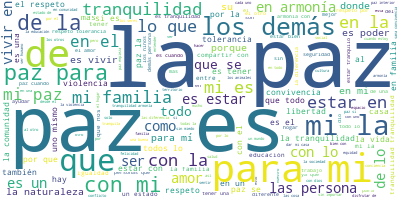

In [101]:
wordcloud.to_image()

En esta imagen podemos observar las diferentes palabras que se encuentran en los textos. Aquí podemos observar que hay stopwords como mi, la, en, con, es, los cuales no nos proporcionan información relevante y por tanto se debe eliminar.

In [102]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


C:\Users\sami_\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\sami_\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
C:\Users\sami_\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [103]:
df.head()

,Narrativa,Narrativa_processed
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",tranquilidad convivencia casa educación colect...
1,Tiempo en horas de día de semana y de fin de s...,tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...",acción sin daño integración comunitaria respet...
4,Procesos formativos y de multiplicación. Numer...,procesos formativos y de multiplicación numero...


## Lemmatization

Procederemos a realizar la lematización. Esto consiste en convertir las palabras de la siguiente manera: si hay verbos en pasado o futuro los convierte a presente, si hay palabras en tercera persona las convierte a primera persona. 

Podriamos en este paso realizar el proceso de Stemming (convertir la palabra a su root word). Sin embargo, decidimos no implementarlo puesto que convierte las palabras hasta un punto que no nos genera valor, por ejemplo, "Computer" lo convertiría a "Comput" lo cual no es significativo para nuestro objetivo del proyecto. Por tanto, solo nos quedamos con el proceso de lematización. 

La lematización es similar al stemming, pero el primero brinda contexto a las palabras. 


In [104]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [105]:

allowed_postags=['ADJ', 'VERB', 'ADV']
data_list=[]
#allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
for row in df.Narrativa_processed:
    #d_actual=(' '.join(lemEsp.Sentence(lemEsp.parse(row, lemmata=True)).lemmata))
    token_list=""
    text=nlp(row)
    for token in text:
        if len(token.text)>3 and token.pos_ in allowed_postags :
            token_list+=token.lemma_+" "
        elif len(token.text)>3:
            token_list+=token.text+" "
    data_list.append(token_list.rstrip())

In [106]:
data_list

['tranquilidad convivencia casa educación colectividad respetar tranquilidad acceso educación humanización espacio siempre será camino',
 'tiempo horas semana semana padres cuidadores pasar tiempo hijos espacios hijos tiempo horas hijos pasar tiempo padres mayor evidencias mantener familia unir hogar equilibrio hogar mantener familias unir',
 'tranquilidad familia empleabilidad tolerancia tranquilidad hogar satisfacer derechos básico constitucional vivienda alimentación salud educación',
 'acción daño integración comunitario respetar derechos humanos hogar compartir tranquilidad bien común',
 'procesos formativo multiplicación numero alianzas publicar privar numero acciones para protección ddhh tolerancia violencia derechos social concertación',
 'iniciativas cultura ciudadano eventos ciudad promover construcción respeto unión atención salud tranquilidad',
 'comunicación tolerancia concertación tolerancia trabajo empleo violencia ausencia cualquier clase violencia',
 'voluntadcomunicac

In [107]:
df_lemmatized=pd.DataFrame(data=data_list,columns=["Narrativa_lemmatized"])

In [108]:
df_lemmatized.head()

,Narrativa_lemmatized
0,tranquilidad convivencia casa educación colect...
1,tiempo horas semana semana padres cuidadores p...
2,tranquilidad familia empleabilidad tolerancia ...
3,acción daño integración comunitario respetar d...
4,procesos formativo multiplicación numero alian...


In [109]:
df.columns

Index(['Narrativa', 'Narrativa_processed'], dtype='object')

La lista de textos lematizados ahora se pasan a una nueva columna del dataframe llamada Narrativa_lemmatized

In [110]:
df["Narrativa_lemmatized"]= df_lemmatized.values

C:\Users\sami_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [111]:
df.head(100)

,Narrativa,Narrativa_processed,Narrativa_lemmatized
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",tranquilidad convivencia casa educación colect...,tranquilidad convivencia casa educación colect...
1,Tiempo en horas de día de semana y de fin de s...,tiempo en horas de día de semana y de fin de s...,tiempo horas semana semana padres cuidadores p...
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad tolerancia ...,tranquilidad familia empleabilidad tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...",acción sin daño integración comunitaria respet...,acción daño integración comunitario respetar d...
4,Procesos formativos y de multiplicación. Numer...,procesos formativos y de multiplicación numero...,procesos formativo multiplicación numero alian...
5,"INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...",iniciativas de cultura ciudadana eventos de ci...,iniciativas cultura ciudadano eventos ciudad p...
6,"Comunicación, tolerancia, concertación. Tolera...",comunicación tolerancia concertación toleranci...,comunicación tolerancia concertación toleranci...
7,"Voluntad,comunicación, Reglas Respeto Toleranc...",voluntadcomunicación reglas respeto tolerancia...,voluntadcomunicación reglas respetar toleranci...
8,1. Sensibilidad social respecto temáticas coti...,sensibilidad social respecto temáticas cotidia...,sensibilidad social respecto temático cotidian...
9,"Cambio de percepción comunitaria, fortalecimie...",cambio de percepción comunitaria fortalecimien...,cambio percepción comunitario fortalecimiento ...


## Tokenization

Ahora convertiremos las oraciones en tokens (palabras). A esto se le llama Tokenization

In [112]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc= True))  # deacc=True removes punctuations

df["Narrativa_lemmatized"] = list(sent_to_words(df["Narrativa_lemmatized"]))

C:\Users\sami_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Bigrams and Trigrams

Consiste en encontrar conjuntos de 2 (bi) o 3 (tri) palabras que formen significado

In [113]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['Narrativa_lemmatized'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['Narrativa_lemmatized']], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

df['Narrativa_lemmatized'] = make_bigrams(df['Narrativa_lemmatized'])
df['Narrativa_lemmatized'] = make_trigrams(df['Narrativa_lemmatized'])

C:\Users\sami_\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\sami_\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [114]:
df.head(100)

,Narrativa,Narrativa_processed,Narrativa_lemmatized
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",tranquilidad convivencia casa educación colect...,"[tranquilidad, convivencia, casa, educacion, c..."
1,Tiempo en horas de día de semana y de fin de s...,tiempo en horas de día de semana y de fin de s...,"[tiempo, horas, semana, semana, padres, cuidad..."
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad tolerancia ...,"[tranquilidad, familia, empleabilidad, toleran..."
3,"Acción sin daño, integración comunitaria, resp...",acción sin daño integración comunitaria respet...,"[accion, dano, integracion, comunitario, respe..."
4,Procesos formativos y de multiplicación. Numer...,procesos formativos y de multiplicación numero...,"[procesos, formativo, multiplicacion, numero, ..."
5,"INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...",iniciativas de cultura ciudadana eventos de ci...,"[iniciativas, cultura, ciudadano, eventos, ciu..."
6,"Comunicación, tolerancia, concertación. Tolera...",comunicación tolerancia concertación toleranci...,"[comunicacion, tolerancia, concertacion, toler..."
7,"Voluntad,comunicación, Reglas Respeto Toleranc...",voluntadcomunicación reglas respeto tolerancia...,"[reglas, respetar, tolerancia, hogar, estado, ..."
8,1. Sensibilidad social respecto temáticas coti...,sensibilidad social respecto temáticas cotidia...,"[sensibilidad, social, respecto, tematico, cot..."
9,"Cambio de percepción comunitaria, fortalecimie...",cambio de percepción comunitaria fortalecimien...,"[cambio, percepcion, comunitario, fortalecimie..."


Podemos observar que creo bigramas como:
 - medio_ambiente
 - iniciativas_comunitarias
 - cultura_ciudadana

## Remove Stop words

Se quitan las palabras que son conocidas como "Stop words": lo, la, con, antes, sin, de, entre otras.

In [115]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sami_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sami_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [116]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')


In [117]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

Se remueven las stopwords de la columna pre-procesada

In [118]:
df['Narrativa_lemmatized'] = remove_stopwords(df['Narrativa_lemmatized'])

C:\Users\sami_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
df.head(100)

,Narrativa,Narrativa_processed,Narrativa_lemmatized
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",tranquilidad convivencia casa educación colect...,"[tranquilidad, convivencia, casa, educacion, c..."
1,Tiempo en horas de día de semana y de fin de s...,tiempo en horas de día de semana y de fin de s...,"[tiempo, horas, semana, semana, padres, cuidad..."
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad tolerancia ...,"[tranquilidad, familia, empleabilidad, toleran..."
3,"Acción sin daño, integración comunitaria, resp...",acción sin daño integración comunitaria respet...,"[accion, dano, integracion, comunitario, respe..."
4,Procesos formativos y de multiplicación. Numer...,procesos formativos y de multiplicación numero...,"[procesos, formativo, multiplicacion, numero, ..."
5,"INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...",iniciativas de cultura ciudadana eventos de ci...,"[iniciativas, cultura, ciudadano, eventos, ciu..."
6,"Comunicación, tolerancia, concertación. Tolera...",comunicación tolerancia concertación toleranci...,"[comunicacion, tolerancia, concertacion, toler..."
7,"Voluntad,comunicación, Reglas Respeto Toleranc...",voluntadcomunicación reglas respeto tolerancia...,"[reglas, respetar, tolerancia, hogar, tranquil..."
8,1. Sensibilidad social respecto temáticas coti...,sensibilidad social respecto temáticas cotidia...,"[sensibilidad, social, respecto, tematico, cot..."
9,"Cambio de percepción comunitaria, fortalecimie...",cambio de percepción comunitaria fortalecimien...,"[cambio, percepcion, comunitario, fortalecimie..."


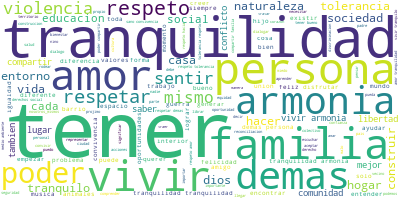

In [120]:
# Join the different processed titles together.
long_string= ""
for text in df['Narrativa_lemmatized']:
    for token in text:
        long_string += token + ","
    
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## LDA (latent Dirichlet Allocation)

Document-word matrix

In [121]:
# Join the different processed titles together.
data_lemmatized= []
for text in df['Narrativa_lemmatized']:
    for token in text:
        data_lemmatized.append(token)

data_lemmatized[:20]

['tranquilidad',
 'convivencia',
 'casa',
 'educacion',
 'colectividad',
 'respetar',
 'tranquilidad',
 'acceso',
 'educacion',
 'humanizacion',
 'espacio',
 'siempre',
 'sera',
 'camino',
 'tiempo',
 'horas',
 'semana',
 'semana',
 'padres',
 'cuidadores']

In [122]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

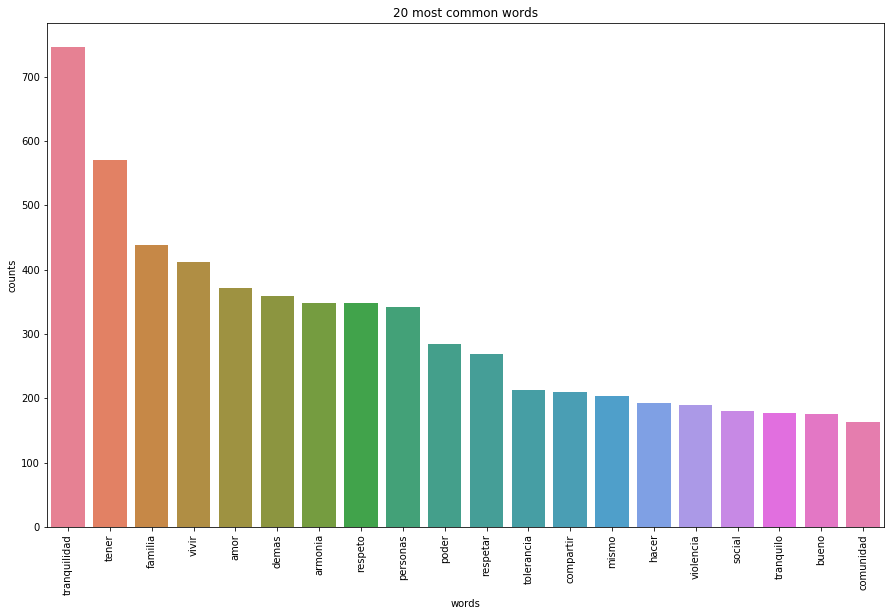

In [123]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Visualise the 10 most common words
plot_10_most_common_words(data_vectorized, vectorizer)

Construcción del modelo

In [124]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [125]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_words = 10

print_topics(lda_model,vectorizer,number_words)


Topic #0:
familia violencia construir entorno educacion ambiente querer tolerante podamos llevar

Topic #1:
demas poder bueno saber generar igualdad representar trabajo escuchar importar

Topic #2:
respetar casa lugar persona derechos animales feliz entender pais cultura

Topic #3:
social mundo ayudar disfrutar salud musica solo felicidad creer siempre

Topic #4:
respeto armonia compartir empezar llegar projimo ciudad debemos partir considerar

Topic #5:
tranquilidad tener mismo hacer sentir mejor convivir libertad interior cosas

Topic #6:
tranquilo vida amigos hacia conflictos diferente ninos oportunidades barrio existir

Topic #7:
personas comunidad naturaleza bien cada sociedad pensar valores seres problemas

Topic #8:
vivir amor dios hogar manera medio encontrar construccion ejemplo colectivo

Topic #9:
tolerancia convivencia tambien union mismos importante vecinos amar perdonar tratar


In [126]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne', sort_topics= False)
panel

C:\Users\sami_\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 1min 11s


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      183.885925   60.996250       1        1   9.477021
1     -220.446564 -139.000046       2        1  10.155480
2     -137.298035  218.534607       3        1  10.047250
3      -94.808685  -54.461140       4        1   9.622405
4       63.803036  191.463806       5        1   9.004523
5       49.198727  -14.764759       6        1  12.490510
6      141.474396 -138.002457       7        1  10.159519
7      -26.844452 -198.555206       8        1  10.624748
8     -228.048477   52.828632       9        1   9.072369
9      -57.011314   89.882462      10        1   9.346176, topic_info=    Category        Freq          Term       Total  loglift  logprob
467  Default  547.000000  tranquilidad  547.000000  30.0000  30.0000
495  Default  448.000000         vivir  448.000000  29.0000  29.0000
188  Default  443.000000       familia  443.000000  28.0000  28.0000
449  Default  485.000000         tener  485.000000  27.0000  27.0000
28   Default  387.000000          amor  387.000000  26.0000  26.0000
401  Default  356.000000       respeto  356.000000  25.0000  25.0000
38   Default  354.000000       armonia  354.000000  24.0000  24.0000
129  Default  358.000000         demas  358.000000  23.0000  23.0000
348  Default  323.000000      personas  323.000000  22.0000  22.0000
353  Default  277.000000         poder  277.000000  21.0000  21.0000
400  Default  242.000000      respetar  242.000000  20.0000  20.0000
77   Default  227.000000     compartir  227.000000  19.0000  19.0000
458  Default  197.000000    tolerancia  197.000000  18.0000  18.0000
492  Default  169.000000     violencia  169.000000  17.0000  17.0000
55   Default  171.000000         bueno  171.000000  16.0000  16.0000
469  Default  168.000000     tranquilo  168.000000  15.0000  15.0000
436  Default  163.000000        social  163.000000  14.0000  14.0000
150  Default  157.000000          dios  157.000000  13.0000  13.0000
292  Default  179.000000         mismo  179.000000  12.0000  12.0000
102  Default  153.000000   convivencia  153.000000  11.0000  11.0000
490  Default  155.000000          vida  155.000000  10.0000  10.0000
222  Default  168.000000         hacer  168.000000   9.0000   9.0000
83   Default  147.000000     comunidad  147.000000   8.0000   8.0000
99   Default  138.000000     construir  138.000000   7.0000   7.0000
68   Default  141.000000          casa  141.000000   6.0000   6.0000
169  Default  135.000000       entorno  135.000000   5.0000   5.0000
306  Default  140.000000    naturaleza  140.000000   4.0000   4.0000
229  Default  120.000000         hogar  120.000000   3.0000   3.0000
158  Default  121.000000     educacion  121.000000   2.0000   2.0000
52   Default  127.000000          bien  127.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
458  Topic10  196.153127    tolerancia  197.040776   2.3657  -2.2856
102  Topic10  152.601405   convivencia  153.489054   2.3644  -2.5367
446  Topic10  113.304305       tambien  114.191954   2.3624  -2.8345
478  Topic10   86.794312         union   87.681961   2.3600  -3.1010
293  Topic10   59.262109        mismos   60.149758   2.3553  -3.4826
240  Topic10   58.462440    importante   59.350089   2.3551  -3.4962
484  Topic10   55.302125       vecinos   56.189774   2.3543  -3.5517
23   Topic10   48.293084          amar   49.180733   2.3520  -3.6873
344  Topic10   48.169773      perdonar   49.057423   2.3519  -3.6898
472  Topic10   41.951249        tratar   42.838899   2.3493  -3.8280
315  Topic10   39.739944      nosotros   40.627593   2.3481  -3.8822
92   Topic10   38.140395       conmigo   39.028044   2.3472  -3.9233
345  Topic10   36.824229      permitir   37.711878   2.3464  -3.9584
18   Topic10   36.115751       alegria   37.003400   2.3459  -3.9778
3    Topic10   34.929362      acciones   35.817011   2.3451  -4.0112
53   Topic10   34.

Bag of Words

In [195]:
data = df["Narrativa_lemmatized"].values.tolist()
data[0:5]

[['tranquilidad',
  'convivencia',
  'casar',
  'educación',
  'colectividad',
  'respetar',
  'tranquilidad',
  'acceso',
  'educación',
  'humanización',
  'espaciar',
  'siempre',
  'ser',
  'caminar'],
 ['tiempo',
  'hora',
  'día',
  'semana',
  'fin',
  'semana',
  'padre',
  'cuidador',
  'pasar',
  'tiempo',
  'hijo',
  'espacio',
  'ie',
  'hijo',
  'tiempo',
  'hora',
  'hijo',
  'pasar',
  'tiempo',
  'padre',
  'mayor',
  'evidenciar',
  'mantener',
  'familia',
  'unir',
  'hogar',
  'equilibrio',
  'hogar',
  'mantener',
  'familia',
  'unir'],
 ['tranquilidad',
  'familia',
  'empleabilidad',
  'tolerancia',
  'tranquilidad',
  'hogar',
  'paz',
  'ser',
  'satisfacer',
  'derecho',
  'básico',
  'constitucional',
  'vivienda',
  'alimentación',
  'salud',
  'educación'],
 ['acción',
  'dañar',
  'integración',
  'comunitario',
  'respetar',
  'derecho',
  'humano',
  'hogar',
  'compartir',
  'tranquilidad',
  'paz',
  'ser',
  'bien',
  'común'],
 ['proceso',
  'format

In [196]:
dictionary = gensim.corpora.Dictionary(data)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 acceso
1 caminar
2 casar
3 colectividad
4 convivencia
5 educación
6 espaciar
7 humanización
8 respetar
9 ser
10 siempre


In [197]:
len(dictionary)

2209

Filter out tokens that appear in
less than 15 documents (absolute number) or
more than 0.5 documents (fraction of total corpus size, not absolute number).
after the above two steps, keep only the first 100000 most frequent tokens.

In [198]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)

In [199]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data]
bow_corpus[1000]

[(6, 3),
 (38, 1),
 (43, 1),
 (58, 1),
 (269, 1),
 (273, 1),
 (330, 1),
 (351, 1),
 (353, 1),
 (373, 1),
 (437, 1),
 (446, 1),
 (447, 1),
 (448, 1),
 (449, 1),
 (450, 1),
 (451, 1)]

In [200]:
bow_doc_1000 = bow_corpus[1000]
for i in range(len(bow_doc_1000)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1000[i][0], 
                                               dictionary[bow_doc_1000[i][0]], 
bow_doc_1000[i][1]))

Word 6 ("respetar") appears 3 time.
Word 38 ("parir") appears 1 time.
Word 43 ("ciudad") appears 1 time.
Word 58 ("demás") appears 1 time.
Word 269 ("habitante") appears 1 time.
Word 273 ("físico") appears 1 time.
Word 330 ("fomentar") appears 1 time.
Word 351 ("integridad") appears 1 time.
Word 353 ("naturaleza") appears 1 time.
Word 373 ("colaboración") appears 1 time.
Word 437 ("animal") appears 1 time.
Word 446 ("cero") appears 1 time.
Word 447 ("corrupción") appears 1 time.
Word 448 ("deportar") appears 1 time.
Word 449 ("material") appears 1 time.
Word 450 ("modo") appears 1 time.
Word 451 ("máximo") appears 1 time.


TF-IDF

In [201]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3879495950102895),
 (1, 0.3755370577876941),
 (2, 0.24594172925634347),
 (3, 0.23671362364125753),
 (4, 0.5207858193422347),
 (5, 0.3727114308502359),
 (6, 0.1420033457222307),
 (7, 0.32884885204807995),
 (8, 0.23131830482799817)]


In [202]:
len(dictionary)

808

In [203]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [204]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.061*"parir" + 0.037*"tranquilidad" + 0.036*"tener" + 0.030*"poder" + 0.027*"vivir" + 0.026*"respetar" + 0.018*"mismo" + 0.017*"haber" + 0.017*"demás" + 0.015*"familia"
Topic: 1 
Words: 0.063*"familia" + 0.041*"libertar" + 0.038*"parir" + 0.031*"tranquilidad" + 0.024*"casar" + 0.023*"poder" + 0.018*"bien" + 0.017*"músico" + 0.015*"sentir" + 0.012*"ambientar"
Topic: 2 
Words: 0.039*"demás" + 0.033*"respetar" + 0.030*"convivencia" + 0.023*"tolerancia" + 0.022*"social" + 0.022*"unir" + 0.018*"tener" + 0.016*"parir" + 0.015*"equidad" + 0.014*"oportunidad"
Topic: 3 
Words: 0.037*"parir" + 0.032*"tranquilidad" + 0.027*"haber" + 0.021*"si" + 0.021*"perdonar" + 0.019*"tener" + 0.017*"comer" + 0.014*"amor" + 0.014*"asir" + 0.013*"ir"
Topic: 4 
Words: 0.047*"parir" + 0.033*"respetar" + 0.021*"tener" + 0.019*"poder" + 0.018*"mismo" + 0.018*"vivir" + 0.017*"demás" + 0.016*"personar" + 0.014*"violencia" + 0.013*"armonía"
Topic: 5 
Words: 0.095*"parir" + 0.025*"poder" + 0.022*"hace